In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import random
import string
import tensorflow as tf
import tensorflow.python.ops.rnn_cell 
from tensorflow.python.framework import registry
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import collections
import matplotlib.pyplot as plt
import codecs
import time
import os
import gc
from six.moves import cPickle as pickle
import sys

from plot_module import text_plot
from plot_module import structure_vocabulary_plots
from plot_module import text_boundaries_plot
from plot_module import ComparePlots

from model_module import maybe_download
from model_module import read_data
from model_module import check_not_one_byte
from model_module import id2char
from model_module import char2id
from model_module import BatchGenerator
from model_module import characters
from model_module import batches2string
from model_module import logprob
from model_module import sample_distribution
from model_module import MODEL

version = sys.version_info[0]

In [2]:
if not os.path.exists('enwik8_filtered'):
    if not os.path.exists('enwik8'):
        filename = maybe_download('enwik8.zip', 36445475)
    full_text = read_data(filename)
    new_text = u""
    new_text_list = list()
    for i in range(len(full_text)):
        if (i+1) % 10000000 == 0:
            print("%s characters are filtered" % i)
        if ord(full_text[i]) < 256:
            new_text_list.append(full_text[i])
    text = new_text.join(new_text_list)
    del new_text_list
    del new_text
    del full_text

    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)
    
    f = open('enwik8_filtered', 'wb')
    f.write(text.encode('utf8'))
    f.close()
    
else:
    f = open('enwik8_filtered', 'rb')
    text = f.read().decode('utf8')
    f.close() 
    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)    

number of not one byte characters:  0
min order index:  9
max order index:  255
total number of characters:  196


In [5]:
#different
offset = 20000
valid_size = 2000
valid_text = text[offset:offset+valid_size]
train_text = text[offset+valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99358000 revolutionary settings. But at the same time, they denounced act
2000 ture in Mutual Aid: A Factor of Evolution (1897). Subsequent ana


In [6]:
vocabulary_size = number_of_characters
vocabulary = list()
characters_positions_in_vocabulary = list()

character_position_in_vocabulary = 0
for i in range(256):
    if present_characters_indices[i]:
        if version >= 3:
            vocabulary.append(chr(i))
        else:
            vocabulary.append(unichr(i))
        characters_positions_in_vocabulary.append(character_position_in_vocabulary)
        character_position_in_vocabulary += 1
    else:
        characters_positions_in_vocabulary.append(-1)


string_vocabulary = u""
for i in range(vocabulary_size):
    string_vocabulary += vocabulary[i]
print("Vocabulary: ", string_vocabulary)
print("char2id(u'a') = %s,  char2id(u'z') = %s,  char2id(u' ') = %s" % (char2id(u'a', characters_positions_in_vocabulary),
                                                                        char2id(u'z', characters_positions_in_vocabulary),
                                                                        char2id(u' ', characters_positions_in_vocabulary)))
print("id2char(78) = %s,  id2char(156) = %s,  id2char(140) = %s" % (id2char(78,
                                                                            vocabulary),
                                                                    id2char(156,
                                                                            vocabulary),
                                                                    id2char(140,
                                                                            vocabulary)))


Vocabulary:  	
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¥¦§¨©ª«¬­®¯°±²³´µ¶·¸¹º»¼½¾¿ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿ
char2id(u'a') = 67,  char2id(u'z') = 92,  char2id(u' ') = 2
id2char(78) = l,  id2char(156) = Ø,  id2char(140) = È


In [7]:
batch_size_test=64
num_unrollings_test=10

train_batches_test = BatchGenerator(train_text,
                                    batch_size_test,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    num_unrollings_test)
valid_batches_test = BatchGenerator(valid_text,
                                    1,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    1)

print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))

['revolutiona', 'col-3}}\n*[[', 'Category:Ca', 'ician in La', 'ianity | ch', ' Locride]]\n', 'mirror]]s (', 'ittsburgh, ', ' acid in Ge', 'American mu', 'veman Speak', 'iticised fa', 'meeting [[p', 'nside of an', 'ny of the P', 'ly thin, bu', 'ball| publi', ' in the fla', 'r his effor', "haniel's Nu", 'cross their', "n O'Higgins", 'cial experi', 'ri Lanka) t', 'tial amino ', 'nfluence in', 'n===\nThe [[', ' The pyrami', 'ite box tes', 'se uses, th', ' birth of m', 'rse &lt;mat', 'le &quot;[[', ' [[Sharon, ', 'a bitter co', 'progress si', '20;Vedic sa', ' music on t', 'harmonium) ', 'r has jumpe', 'band and wi', '===\n*[[Thom', 'irst has to', ' overview, ', ' which send', 'rging Techn', 'orld Cup 20', 'ions of the', 'scattering ', '43.\n* 21st ', 'ory:Sega Sa', 'hortages, [', 'ot;. The wo', 'ssy and Rav', 'd, isolated', 't the [[Bat', 'official la', ' it was pro', 'e time as h', 'etrain comp', 'f Guardians', ']] (Richmon', ';/TD&gt;\n  ', 's, extraord']
['ary setting', '[Artery]]\n*', '

In [9]:
indices_GL = {"batch_size": 0,
              "num_unrollings": 1,
              "num_layers": 2,
              "num_nodes": 3,
              "half_life": 4,
              "decay": 5,
              "num_steps": 6,
              "averaging_number": 7,
              "type": 8}


class LSTM(MODEL):
    def __init__(self,
                 batch_size,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 num_unrollings,
                 num_layers,
                 num_nodes,
                 train_text,
                 valid_text):
        self._results = list()
        self._batch_size = batch_size
        self._vocabulary = vocabulary
        self._vocabulary_size = len(vocabulary)
        self._characters_positions_in_vocabulary = characters_positions_in_vocabulary
        self._num_unrollings = num_unrollings
        self._num_layers = num_layers
        self._num_nodes = num_nodes
        self._train_text = train_text
        self._valid_text = valid_text
        self._valid_size = len(valid_text)
        self._indices = {"batch_size": 0,
                         "num_unrollings": 1,
                         "num_layers": 2,
                         "num_nodes": 3,
                         "half_life": 4,
                         "decay": 5,
                         "num_steps": 6,
                         "averaging_number": 7,
                         "type": 8}
        self._graph = tf.Graph()
        
        self._last_num_steps = 0
        with self._graph.as_default(): 
            with self._graph.device('/gpu:0'): 
                #list of LSTM cells in multilayered network
                cell_list = list()
                for i in range(self._num_layers):
                    cell_list.append(tf.nn.rnn_cell.BasicLSTMCell(self._num_nodes[i], state_is_tuple=True))
                LSTM = tf.nn.rnn_cell.MultiRNNCell(cell_list, state_is_tuple=True)
                zeros_init = tf.zeros_initializer()
                weights_initializer = tf.truncated_normal_initializer(mean=0., stddev=0.1, seed=None, dtype=tf.float32)
                LSTM_scope = 'LSTM'
                with tf.variable_scope(LSTM_scope, reuse=False):
                  for i in range(self._num_layers):
                    with tf.variable_scope("Cell%d" % i):
                      with tf.variable_scope("BasicLSTMCell"):
                        with tf.variable_scope("Linear"):
                          if i == 0:
                            input_dim = self._vocabulary_size + cell_list[i].output_size
                          else:
                            input_dim = cell_list[i-1].output_size + cell_list[i].output_size
                          output_dim = 4*cell_list[i].output_size
                          tf.get_variable("Matrix", [input_dim, output_dim], initializer=weights_initializer)
                          tf.get_variable("Bias", 
                                          shape=[output_dim],
                                          initializer=zeros_init)

                # classifier 
                weights = tf.Variable(tf.truncated_normal([LSTM.output_size, self._vocabulary_size], stddev = 0.1))
                bias = tf.Variable(tf.zeros([self._vocabulary_size]))
                
                """PLACEHOLDERS train data"""
                self._train_data = list()
                for _ in range(self._num_unrollings + 1):
                    self._train_data.append(
                        tf.placeholder(tf.float32, shape=[self._batch_size, self._vocabulary_size]))
                train_inputs = self._train_data[: self._num_unrollings]
                train_labels = self._train_data[1:]  # labels are inputs shifted by one time step.
                # Unrolled LSTM loop.

                saved_state = list()
                for i in range(self._num_layers):
                    zero_c, zero_h = cell_list[i].zero_state(self._batch_size, tf.float32)
                    shape_c = zero_c.get_shape().as_list()
                    shape_h = zero_h.get_shape().as_list()
                    saved_state.append((tf.Variable(tf.zeros(shape_c), trainable=False),
                                        tf.Variable(tf.zeros(shape_h), trainable=False)))    #AMENDMENT!!!!

                outputs = list()
                state = saved_state
                for i in train_inputs:
                    with tf.variable_scope('', reuse=True): 
                        output, state = LSTM(i, state, scope=LSTM_scope)
                    outputs.append(output)

                save_list = list()
                for i in range(self._num_layers):
                    save_list.append(saved_state[i][0].assign(state[i][0]))
                    save_list.append(saved_state[i][1].assign(state[i][1]))
                
                """skip operation"""
                self._skip_operation = tf.group(*save_list)

                with tf.control_dependencies(save_list):
                        # Classifier.
                    logits = tf.nn.xw_plus_b(tf.concat(0, outputs), weights, bias)
                    """loss"""
                    self._loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                        logits, tf.concat(0, train_labels)))
                # Optimizer.
                self._global_step = tf.Variable(0)
                """PLACEHOLDERS half life and decay"""
                self._half_life = tf.placeholder(tf.int32)
                self._decay = tf.placeholder(tf.float32)
                """learning rate"""
                self._learning_rate = tf.train.exponential_decay(10.0,
                                                                 self._global_step,
                                                                 self._half_life,
                                                                 self._decay,
                                                                 staircase=True)
                optimizer = tf.train.GradientDescentOptimizer(self._learning_rate)
                gradients, v = zip(*optimizer.compute_gradients(self._loss))
                gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
                """optimizer"""
                self._optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=self._global_step)
                """train prediction"""
                self._train_prediction = tf.nn.softmax(logits)

                # Sampling and validation eval: batch 1, no unrolling.
                saved_sample_state = list()

                for i in range(self._num_layers):
                    sample_zero_c, sample_zero_h = cell_list[i].zero_state(1, tf.float32)
                    sample_shape_c = sample_zero_c.get_shape().as_list()
                    sample_shape_h = sample_zero_h.get_shape().as_list()
                    saved_sample_state.append((tf.Variable(tf.zeros(sample_shape_c)), tf.Variable(tf.zeros(sample_shape_h))))  
                """PLACEHOLDER sample input"""
                self._sample_input = tf.placeholder(tf.float32, shape=[1, self._vocabulary_size])

                reset_list = list()
                for i in range(self._num_layers):
                    sample_zero_c, sample_zero_h = cell_list[i].zero_state(1, tf.float32)
                    sample_shape_c = sample_zero_c.get_shape().as_list()
                    sample_shape_h = sample_zero_h.get_shape().as_list()
                    reset_list.append(saved_sample_state[i][0].assign(tf.zeros(sample_shape_c)))
                    reset_list.append(saved_sample_state[i][1].assign(tf.zeros(sample_shape_h)))
                """reste sample state"""
                self._reset_sample_state = tf.group(*reset_list)

                with tf.variable_scope('', reuse=True): 
                    sample_output, sample_state = LSTM(self._sample_input, saved_sample_state, scope=LSTM_scope)

                sample_save_list = list()
                for i in range(self._num_layers):
                    sample_save_list.append(saved_sample_state[i][0].assign(sample_state[i][0]))
                    sample_save_list.append(saved_sample_state[i][1].assign(sample_state[i][1]))    

                with tf.control_dependencies(sample_save_list):
                    """sample prediction"""
                    self._sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, weights, bias)) 
                
                Matrices = list()
                Biases = list()
                gates = list()
                with tf.variable_scope(LSTM_scope, reuse=True):
                    for i in range(self._num_layers):
                        with tf.variable_scope("Cell%d" % i):
                            with tf.variable_scope("BasicLSTMCell/Linear"):
                                Matrices.append(tf.get_variable("Matrix"))
                                Biases.append(tf.get_variable("Bias"))
                cur_inp = self._sample_input
                for layer_num in range(self._num_layers):
                    concat = tf.matmul(tf.concat(1, [cur_inp,
                                                     saved_sample_state[layer_num][1]]),
                                       Matrices[layer_num]) + Biases[layer_num]
                    i, _, f, o = tf.split(1, 4, concat)
                    gates.append(tf.concat(0,
                                           [tf.sigmoid(i),
                                            tf.sigmoid(f),
                                            tf.sigmoid(o)]))
                    with tf.variable_scope(LSTM_scope, reuse=True):
                        with tf.variable_scope("Cell%d" % layer_num):
                            cur_inp, _ = cell_list[layer_num](cur_inp, saved_sample_state[layer_num])
                    
                """gates"""
                #important changes were made
                self.gates = tf.concat(1, gates)
                
                """saver"""
                self.saver = tf.train.Saver(max_to_keep=None)
                            
                        
    
    def _generate_metadata(self, half_life, decay, num_averaging_iterations):
        metadata = list()
        metadata.append(self._batch_size)
        metadata.append(self._num_unrollings)
        metadata.append(self._num_layers)
        metadata.append(self._num_nodes)
        metadata.append(half_life)
        metadata.append(decay)
        metadata.append(self._last_num_steps)
        metadata.append(num_averaging_iterations)
        metadata.append('simple')
        return metadata
        
        
    def get_gates(self, session, num_strings=10, length=75, start_positions=None):
        self._reset_sample_state.run()
        self._valid_batches = BatchGenerator(self._valid_text,
                                             1,
                                             self._vocabulary_size,
                                             self._characters_positions_in_vocabulary,
                                             1)
        if start_positions is None:
            start_positions = list()
            if self._valid_size // num_strings < length:
                num_strings = self._valid_size // length
            for i in range(num_strings):
                start_positions.append(i* (self._valid_size // num_strings) + self._valid_size // num_strings // 2)
            while self._valid_size - start_positions[-1] < length:
                del start_positions[-1]
        text_list = list()
        gate_dict = dict()
        aver_gate_dict = dict()
        correct_order = ['i', 'f', 'o']
        for layer_idx in range(self._num_layers):
            gate_dict[layer_idx+1] = {'i': list(), 'f': list(), 'o': list()}
            aver_gate_dict[layer_idx+1] = {'i': list(), 'f': list(), 'o': list()}
        collect_gates = False
        letters_parsed = -1
        for idx in range(self._valid_size):
            b = self._valid_batches.next()
            
            if idx in start_positions or collect_gates: 
                if letters_parsed == -1:
                    letters_parsed = 0
                    text = u""
                    g_dict = dict()
                    for layer_idx in range(self._num_layers):
                        g_dict[layer_idx+1] = {'i': [list() for _ in range(self._num_nodes[layer_idx])],
                                               'f': [list() for _ in range(self._num_nodes[layer_idx])],
                                               'o': [list() for _ in range(self._num_nodes[layer_idx])]}
                    av_g_dict = dict()
                    for layer_idx in range(self._num_layers):
                        av_g_dict[layer_idx+1] = {'i': list(),
                                                  'f': list(),
                                                  'o': list()}
                    collect_gates = True
                text += characters(b[0], self._vocabulary)[0]
                iteration_gates = self.gates.eval({self._sample_input: b[0]})
                num_gates = iteration_gates.shape[0]
                #print('num_gates: ', num_gates)
                gates_by_layer = list()
                av_gates_by_layer = list()
                start = 0
                for layer_idx in range(self._num_layers):
                    stop = start + self._num_nodes[layer_idx]
                    layer_gates = iteration_gates[:, start : stop]
                    layer_gates_list = list()
                    av_layer_gates_list = list()
                    for gate_idx in range(num_gates):
                        layer_gates_list.append(list(np.squeeze(layer_gates[gate_idx : gate_idx+1, :])))
                        av_layer_gates_list.append(np.mean(layer_gates[gate_idx : gate_idx+1, :]))
                    gates_by_layer.append(layer_gates_list)
                    av_gates_by_layer.append(av_layer_gates_list)
                    start += self._num_nodes[layer_idx]
                for layer_idx in range(self._num_layers):
                    for gate_idx, gate_type in enumerate(correct_order):
                        av_g_dict[layer_idx+1][gate_type].append(av_gates_by_layer[layer_idx][gate_idx])
                        for node_idx, node_value in enumerate(gates_by_layer[layer_idx][gate_idx]):
                            g_dict[layer_idx+1][gate_type][node_idx].append(node_value)
                letters_parsed += 1
                if letters_parsed >= length:
                    collect_gates = False
                    for layer_key in gate_dict.keys():
                        for gate_key in gate_dict[layer_key].keys():
                            gate_dict[layer_key][gate_key].append(g_dict[layer_key][gate_key])
                            aver_gate_dict[layer_key][gate_key].append(av_g_dict[layer_key][gate_key])
                    text_list.append(text)
                    letters_parsed = -1
                    
            _ = self._sample_prediction.eval({self._sample_input: b[0]})
        return text_list, gate_dict, aver_gate_dict   

In [10]:

model = LSTM(53,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 10,
                 1,
                 [112],
                 train_text,
                 valid_text)

ValueError: Variable LSTM/cell_0/basic_lstm_cell/kernel does not exist, or was not created with tf.get_variable(). Did you mean to set reuse=None in VarScope?

In [ ]:

model.run(1,                # number of times learning_rate is decreased
          0.9,              # a factor by which learning_rate is decreased
            50,            # each 'train_frequency' steps loss and percent correctly predicted letters is calculated
            100,             # minimum number of times loss and percent correctly predicted letters are calculated while learning (train points)
            3,              # if during half total spent time loss decreased by less than 'stop_percent' percents learning process is stopped
            1,              # when train point is obtained validation may be performed
            20,             # when train point percent is calculated results got on averaging_number chunks are averaged
          fixed_number_of_steps=5000,
          save_path="HM_LSTM/new_feature")

"""add_operations=['self.L2_train'],
print_steps=[10, 50, 200],
validation_add_operations = ['self.L2_validation'],
num_validation_prints=10,
print_intermediate_results = True,
summarizing_logdir=logdir"""

In [14]:
model1.simple_run(100,              #minimum number of steps
                             'LSTM/variables/for_gates',               #how often average loss is calculated
                             20000,               #number of steps to be performed before nex try to stop learning
                             4000,
                             5000,#number times learning rate will decay
                             20,                #decay
                             0.9,                  #stop percent
                             3)

Number of steps = 25001     Percentage = 50.02%     Time = 303s     Learning rate = 0.7179


In [34]:
text_list, gate_dict, aver_gate_dict = model1.run_for_analitics(model1.get_gates,
                                                'LSTM/variables/for_gates',
                                                [300, 75, None])

In [35]:
print(aver_gate_dict[1]['i'][0], '\n\n')
print(aver_gate_dict[1]['f'][0], '\n\n')
print(aver_gate_dict[1]['o'][0], '\n\n')

[0.44736058, 0.44591719, 0.50438082, 0.39251682, 0.3258799, 0.56831956, 0.58270282, 0.47345573, 0.4393799, 0.42204279, 0.42402914, 0.42848709, 0.43993461, 0.6024754, 0.49306446, 0.49217862, 0.44256818, 0.50098366, 0.51210922, 0.49082389, 0.58418781, 0.48717958, 0.36881691, 0.35613585, 0.65054238, 0.57384962, 0.48507762, 0.45180616, 0.4430455, 0.39132619, 0.48303035, 0.4479821, 0.47062379, 0.38405079, 0.64562571, 0.54539925, 0.50619388, 0.56139761, 0.57628047, 0.58350796, 0.51323223, 0.5134207, 0.48602289, 0.44271058, 0.34094459, 0.64808857, 0.51911592, 0.55064464, 0.53904998, 0.46158737, 0.49673319, 0.5117861, 0.42029929, 0.63584447, 0.55895495, 0.47164488, 0.51604784, 0.38395584, 0.61884391, 0.50834417, 0.43828946, 0.36619163, 0.46242714, 0.42927799, 0.39566499, 0.27873749, 0.61537665, 0.55645275, 0.43452707, 0.35361749, 0.58599508, 0.49781042, 0.47051752, 0.45069504, 0.39805627] 


[0.24245057, 0.22787109, 0.23906502, 0.20532897, 0.18417752, 0.18914577, 0.18133558, 0.30066636, 0.3440

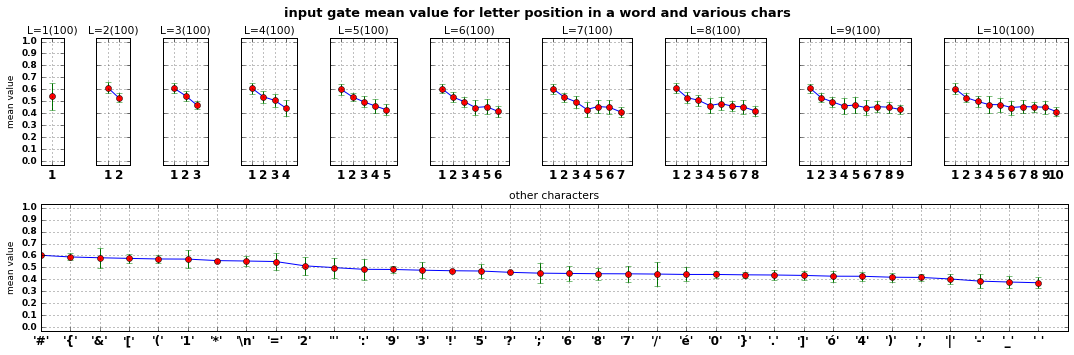

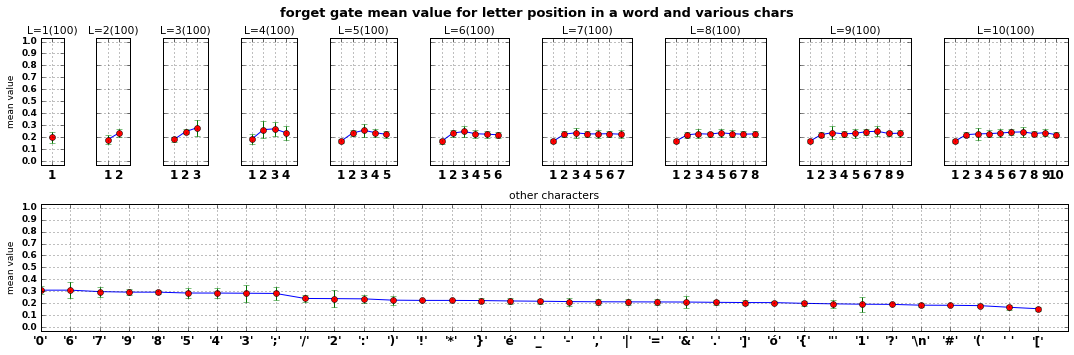

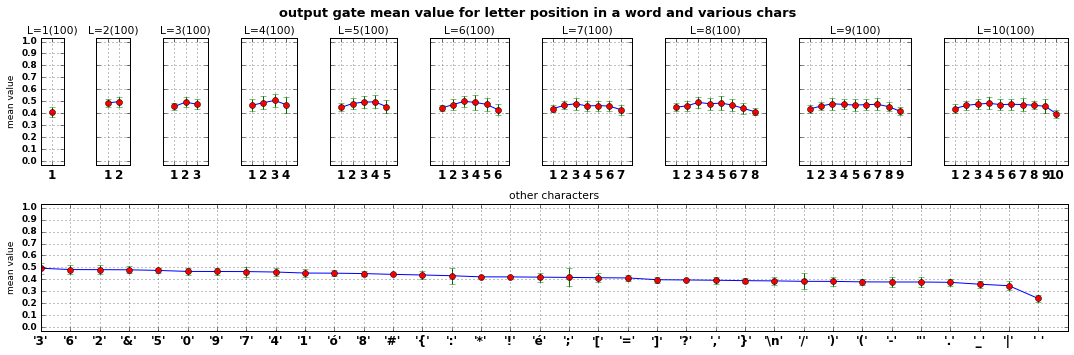

In [37]:
structure_vocabulary_plots(text_list,
                           aver_gate_dict[1]['i'],
                           'input gate mean value for letter position in a word and various chars',
                           'mean value',
                           ['LSTM', 'gates', 'vocabulary'],
                           'mean_input1_64_16_nu_10',
                           ylims=[0., 1.],
                           ylims_fixed=True,
                           show=True)  
structure_vocabulary_plots(text_list,
                           aver_gate_dict[1]['f'],
                           'forget gate mean value for letter position in a word and various chars',
                           'mean value',
                           ['LSTM', 'gates', 'vocabulary'],
                           'mean_forget1_64_16_nu_10',
                           ylims=[0., 1.],
                           ylims_fixed=True,
                           show=True) 
structure_vocabulary_plots(text_list,
                           aver_gate_dict[1]['o'],
                           'output gate mean value for letter position in a word and various chars',
                           'mean value',
                           ['LSTM', 'gates', 'vocabulary'],
                           'mean_output1_64_16_nu_10',
                           ylims=[0., 1.],
                           ylims_fixed=True,
                           show=True) 

In [39]:
for i in range(50):
    text_plot(text_list[i],
          aver_gate_dict[1]['i'][i],
          'input gate',
          'input gate',
          ['LSTM', 'gates', 'text_plots', 'input'],
          'inp1_64_16_nu_10#%s' % i,
          show=False)
    text_plot(text_list[i],
          aver_gate_dict[1]['f'][i],
          'forget gate',
          'forget gate',
          ['LSTM', 'gates', 'text_plots', 'forget'],
          'forget1_64_16_nu_10#%s' % i,
          show=False)
    text_plot(text_list[i],
          aver_gate_dict[1]['o'][i],
          'output gate',
          'output gate',
          ['LSTM', 'gates', 'text_plots', 'output'],
          'output1_64_16_nu_10#%s' % i,
          show=False)

In [10]:
fuse_texts = ['my name is', 'december elegy', 'they have done']
model1.run(20,
            0.9,
            2000,
            5,
            3,
            5,
            20,
            print_intermediate_results = True,
            half_life_fixed = False,
           fuse_texts=fuse_texts)

Initialized
Average loss at step 0: 5.277990 learning rate: 10.000000
Percentage_of correct: 0.00%

random:
«cBÏöCl·ËhAeäÓaqZ1oÔ?tedÖ9o¬}°þ-m­×!Ã%AòRS|Í Èåße*çqFèyá?	ôhp´Eºü½	Ü%³68XoPoiA
3M
 DÃneJåp@mq õ×Dì½mE ^;hÿ5¯A·ËU¡qpøZáÕòÑÝª{óñ{î²5öÚF²ÊÍNÆra¿M3sVÔj~á3kv±Ö;´h&
«­QA©uöel1OíÏ«Ýî£7·ºeÂ"ãQ¼{RIçÙ5é \YÒIñÁiêuÚhÚ65Ü%K\Ú n¥?7ÕF¶p¾pUjßà|¢î«{ø`ì¡îã¹
v~±ÇI;ë×|Suéâaä@¡s[fñ¢*BÆÓë½Äe_oÄßóØ¶@L
Íkk /hîb w8ÔWZÞO1eTrÝÏÁpkõåÜ¢óvvRý g}Y
Ê6Þbs@¸¨ô=*ÆÝ|ÒÉ=ùÄã, ÌéeuøA¯AøA·NïËWÝ8þG"Èt?´­QàCía!V1(· [j{SÉtjüHÃ·®o%ÇZò±ö7^Q

from fuse:
0. fuse: my name is
my name isllòE¹qÖòªµÀ»q·óÉÃiÍåËU;ùJqµÂÉ=ô-û%
|P0¿d¬e0vNôKÀÿ=¬ð«yDèþ¬Èïn«tÄZô¶9£LÚNôv
ñ;·5
1. fuse: december elegy
december elegyèËà-ñ¬ø(hc{@ÖÂRÈW§=B1Ùoûq[NôcÁ{&fÆÎ+KßÈÙ 
·ì}ÞqZPy®Ëa§)])X/sJê'Ãp£.a/s@oa°Èe.(
2. fuse: they have done
they have doneoPg~ðhÜEGÓ ÜzÍ ßÛØ eí4a+Äz úSôà°ã/}U· Zp(]MÀWT+:a:RíÙ÷©î1+«KíÑZoh{ÐTbÑãþD×¿¿s@_
Validation percentage of correct: 13.10%

Average loss at step 10000: 1.931257 learning rate: 8.099999
Percentage_of correct: 50.

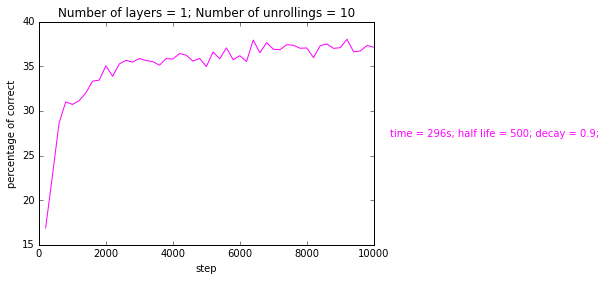

In [10]:
model1.plot([0])

In [10]:
text_list, gate_list = model1.run_for_analitics(model1.get_gates,
                                                'simple/1/saved/16',
                                                [100, 75, None])

In [ ]:
print('text list length: ', len(text_list))
print('gate_list_length: ', len(gate_list))
print('gates length: ', len(gate_list[0]))
print('gate_shape: ', gate_list[0][0].shape)

In [5]:
a = np.array([[1], [2], [3]])
b = list(a)
print(a)
print(b)

[[1]
 [2]
 [3]]
[array([1]), array([2]), array([3])]
